In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from xgcm import Grid

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Reading in data from the varioius paramaterized 1/2 degree runs with GME parameterization (Bachman et al. 2019)

In [60]:
## Gustavo's default KHTH=300
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/KHTH_constant/nw2_0.5deg_N15_KHTH300 
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00032002.nc',decode_times=False)

## Gustavo's default KHTH=500
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/KHTH_constant/nw2_0.5deg_N15_KHTH500
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00032002.nc',decode_times=False)

## MY default KHTH=300 (should be copy of Gustavo's above, just a sanity check since it was my first run)
# %cd /glade/p/univ/unyu0004/eyankovsky/example_elizabeth
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00031502.nc',decode_times=False)

#PARAMETERIZED GME RUNS:
# %cd /glade/p/univ/unyu0004/eyankovsky/Bachman2019_attempt1
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00031502.nc',decode_times=False)

# %cd /glade/p/univ/unyu0004/eyankovsky/Bachman2019_KHTH500_C01
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00031502.nc',decode_times=False)

# %cd /glade/p/univ/unyu0004/eyankovsky/Bachman2019_KHTH500_C1
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00031502.nc',decode_times=False)

%cd /glade/p/univ/unyu0004/eyankovsky/Bachman2019_KHTH500_default
fs= xr.open_dataset('static.nc', decode_times=False)
av = xr.open_dataset('averages_00031502.nc',decode_times=False)



%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/eyankovsky/Bachman2019_KHTH500_default
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [61]:
%%time
xh = fs.xh.values
yh = fs.yh.values
Nlayers=15

grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)
area_t=fs['area_t']

done part 1
done part 2
(100, 15, 280, 120)
CPU times: user 2.44 s, sys: 1.75 s, total: 4.18 s
Wall time: 7.93 s


In [62]:
%%time
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x

print('done 1')

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')


# #Total kinetic energy:
KE_BT_tot=KE_eddy_BT+KE_mean_BT
KE_BC_tot=KE_eddy_BC+KE_mean_BC
KE_tot=KE_BT_tot+KE_BC_tot


fraction_BT=KE_BT_tot/KE_tot
fraction_BT_mean=KE_mean_BT/KE_tot
fraction_BT_eddy=KE_eddy_BT/KE_tot

fraction_BC=KE_BC_tot/KE_tot #when you divide zero/zero it's a nan
fraction_BC_mean=KE_mean_BC/KE_tot
fraction_BC_eddy=KE_eddy_BC/KE_tot

KE_eddy = KE_eddy_BT+ KE_eddy_BC
KE_mean = KE_mean_BT+ KE_eddy_BC

done 1
CPU times: user 654 ms, sys: 614 ms, total: 1.27 s
Wall time: 1.27 s


done


Text(0.5, 1.0, 'KHTH=500, GME_LIMITER=1e7, GME_EFFICIENCY=1.0')

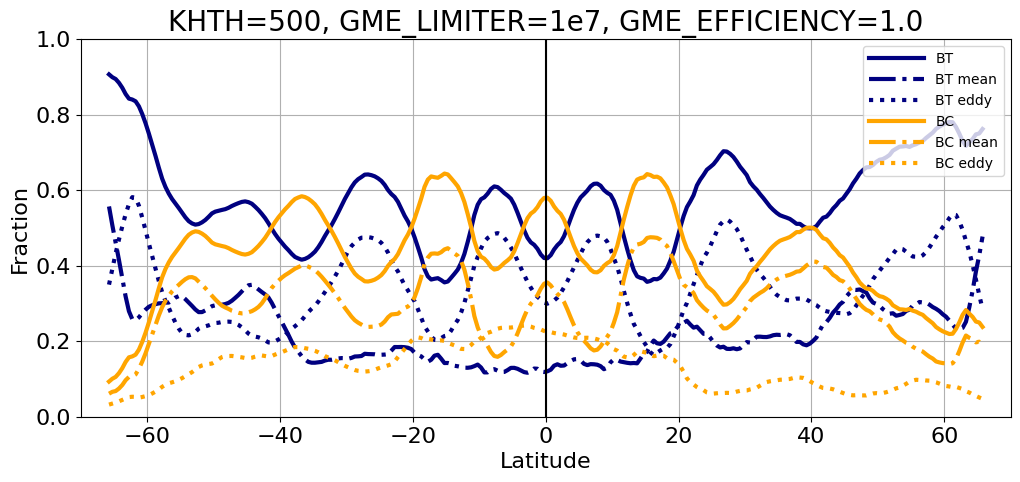

In [63]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=15

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh,np.convolve((fraction_BT.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3)
print('done')
plt.plot(yh,np.convolve((fraction_BT_mean.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c=[0,0,0.5],linewidth=3)
plt.plot(yh,np.convolve((fraction_BT_eddy.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)
plt.grid()
plt.plot(yh,np.convolve((fraction_BC.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.plot(yh,np.convolve((fraction_BC_mean.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c='#FFA500',linewidth=3)
plt.plot(yh,np.convolve((fraction_BC_eddy.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c='#FFA500',linewidth=3)

plt.legend(['BT','BT mean','BT eddy','BC','BC mean','BC eddy'],loc='upper right',fontsize=10,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Fraction',fontsize=16)
plt.title('KHTH=500, GME_LIMITER=1e7, GME_EFFICIENCY=1.0',fontsize=20)
#plt.title('KHTH=500, Default',fontsize=20)

done


Text(0.5, 1.0, 'KHTH=500, GME_LIMITER=1e7, GME_EFFICIENCY=1.0')

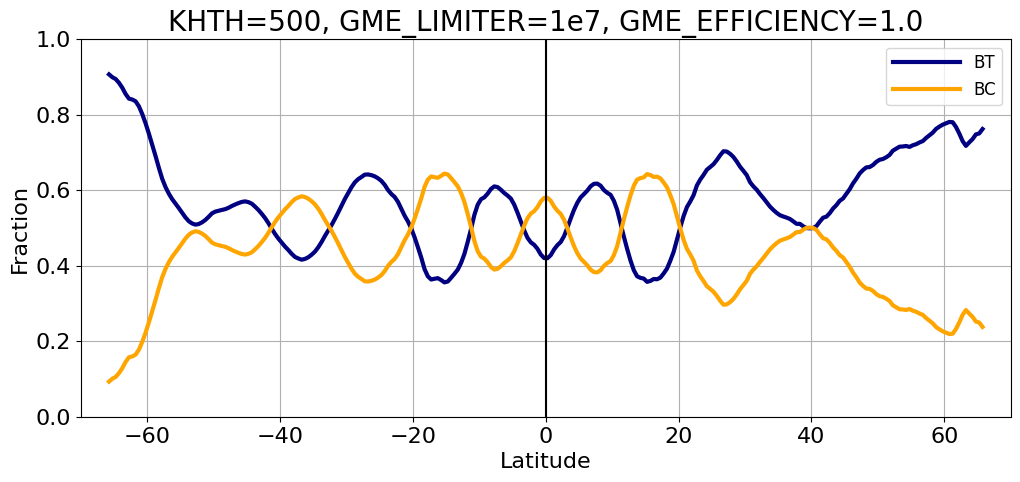

In [64]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=15

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh,np.convolve((fraction_BT.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3)
print('done')
plt.grid()
plt.plot(yh,np.convolve((fraction_BC.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)

plt.legend(['BT','BC'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Fraction',fontsize=16)
plt.title('KHTH=500, GME_LIMITER=1e7, GME_EFFICIENCY=1.0',fontsize=20)
